In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np

import scipy

import keras
from keras.preprocessing import image
from keras.applications import inception_v3
from keras import backend as K

from matplotlib import pyplot as plt

Using TensorFlow backend.


## Import Load and Process Data/Images

In [2]:
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

In [3]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [4]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

## Build Model

In [5]:
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

### Preproccess Data

In [6]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Run Model

In [7]:
step = 0.01  
num_octave = 3  
octave_scale = 1.4  
iterations = 20 

max_loss = 10.

base_image_path = 'data/BewareOfOldMen.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='images/final_dream.png')

Processing image shape (368, 375)
...Loss value at 0 : 1.719542
...Loss value at 1 : 2.2738824
...Loss value at 2 : 2.9161825
...Loss value at 3 : 3.542307
...Loss value at 4 : 4.2374964
...Loss value at 5 : 4.960295
...Loss value at 6 : 5.661136
...Loss value at 7 : 6.353336
...Loss value at 8 : 7.0081534
...Loss value at 9 : 7.6928477
...Loss value at 10 : 8.313251
...Loss value at 11 : 8.959038
...Loss value at 12 : 9.586474


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':


Processing image shape (516, 525)
...Loss value at 0 : 3.0089612
...Loss value at 1 : 4.2931175
...Loss value at 2 : 5.4566584
...Loss value at 3 : 6.5125837
...Loss value at 4 : 7.483758
...Loss value at 5 : 8.415853
...Loss value at 6 : 9.332145
Processing image shape (723, 736)
...Loss value at 0 : 3.320307
...Loss value at 1 : 4.7025156
...Loss value at 2 : 6.1711955
...Loss value at 3 : 7.715108
...Loss value at 4 : 9.941775


## Ouput: DayDream

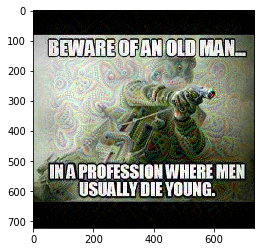

In [8]:
plt.imshow(deprocess_image(np.copy(img)))
plt.show()